# 06. PyTorch Transfer Learing 

**Transfer learning**: Taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pre-trained model = foundation models 

In [1]:
import torch 
import torchvision 

print(f"Torch version: {torch.__version__}") # 1.12+ needed
print(f"Torchvision version: {torchvision.__version__}") # 0.13+ needed
print(f"Cuda available: {torch.cuda.is_available()}")

# Device agnostic code 
dev = "cuda" if torch.cuda.is_available() else "cpu"

Torch version: 1.13.1+cu117
Torchvision version: 0.14.1+cu117
Cuda available: True


In [2]:
# Regular imports
import matplotlib.pyplot as plt 
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo
try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find torchinfo, installing it...")
    !pip install -q torchinfo 
    from torchinfo import summary

# Try to import going_modular 
try:
    from going_modular.going_modular import data_setup, engine 
except:
    print(f"[INFO] Couldn't fin going_modular scripts, downlading them from github...")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning 
    from going_modular.going_modular import data_setup, engine 

In [3]:
# Device agnostic-code
dev = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {dev}")

!nvidia-smi

Device: cuda
Tue Oct  7 12:45:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.09              Driver Version: 580.82.09      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   35C    P3             11W /   70W |      13MiB /   8188MiB |     14%      Default |
|                                         |                        |                  N/A |
+----------------------------------

## 1. Get some data

We need the pizza-steak-sushi data to build a transfer learning model on.

In [4]:
import os 
import zipfile 

from pathlib import Path

import requests 

# Setup data path
data_path = Path(".data")
image_path = data_path/"pizza_steak_sushi"

# If image folder doesn't exists, download and prepare it
if image_path.exists():
    print(f"'{image_path}' already exists, skipping this step.")
else:
    print(f"Did not find '{image_path}', downloading it...")
    
    # Creating the directory 
    image_path.mkdir(parents=True,
                     exist_ok=True)
    
    # Download pizza steak and sushi data
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        # Made the request and get the content 
        req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
        f.write(req.content)
        
    # Unzip data
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip") as zip_ref:
        print("Unzziping pizza, steak & sushi data...")
        zip_ref.extractall(image_path)
        
        # Remove zipfile
        os.remove(data_path/"pizza_steak_sushi.zip")

'.data/pizza_steak_sushi' already exists, skipping this step.


In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir, test_dir

(PosixPath('.data/pizza_steak_sushi/train'),
 PosixPath('.data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders 

Now we've got some data, we want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch going modular.

There's one thing we have to think about when loading: how to **transfrorm** it?

With `torchvision` 0.13+ we have 2 options: 

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like  to use.

**IMPORTANT:** When using a pretrained model, it's important that the data that you pass through it is **transformed** in the same way that the data the model was trained on.



In [6]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)

In [7]:
from torchvision import transforms

# Look at PyTorch docs for this normalization, all pre train models requieres 3 channels RGB, CHW format, where H & W 
# are expected to be at least 224. The model also requieres the data to be in range [0,1] using the next normalization: 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

In [8]:
from going_modular.going_modular import data_setup

BATCH_SIZE = 32

train_dataloder, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=str(train_dir),
                                                                              test_dir=str(test_dir),
                                                                              batch_size=BATCH_SIZE,
                                                                              transform=manual_transform)
train_dataloder, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b031ad254c0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transforms for `torchvision.models` (auto creation)

As `torchvision` v0.13+ there is now support for automatic data transform creation
based on the pretrained model weights you're using.

In [9]:
# Get a set of pretrained model weights 
# We will be using EfficientNet, version B0 (the smalles model with this architecture)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights 
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create dataloaders using automatic transforms 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=str(train_dir),
                                                                               test_dir=str(test_dir),
                                                                               transform=auto_transforms,
                                                                               batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b031ad2a2e0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model 

There are varios places to get a pretrained model, such as:

1. PyTorch domain libraries.
2. Libraries like `timm` (torch image models)
3. HuggingFace club (for plenty of diferent models)
4. Paperswithcode (for models across different problems spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment...!

Idea: Take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to have in mind: 
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem?

Where does the model live?

### 3.2 Setting up a pretrained model

Want to create an instace of a pretrained EffNetB0

In [12]:
# Old method of creating a pretrained model (prior to torchvision v0.13)
#model = torchvision.models.efficientnet_b0(pretrained=True)

In [13]:
# New method of creating a pretrained model 
# Note:
# EfficientNet is the architecture
# B0 is the size of the model (this is the smalles with this arch)
# DEFAULT is to get the best weights available 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "Default" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(dev)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
model.classifier # We must change out_features to 3 (our number of classes)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model whith torchinfo

In [15]:
# Print a summary 
from torchinfo import summary 

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]) # BatchSize x Channels x Height x Weight 


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs.

With a feature extraction model, typically you will freeze the base layers of a pretrained model / foundation model and update the output layers 
to suit your own problem.

In [16]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [17]:
# Freeze all of the base layers 
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
# Update the classifier head of our model to suit our problem
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
# Print a summary 
from torchinfo import summary 

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]) # BatchSize x Channels x Height x Weight 


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Training model

In [20]:
# Define loss & optimizer 
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(),
                         lr=0.001)

In [21]:
# Import traininig function
from going_modular.going_modular import engine

# Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start timer  
from timeit import default_timer as timer
t0 = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optim,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=dev)

# Stop timer
t1 = timer()
print(f"[INFO] Total training time: {t1-t0:.2f} seconds.")



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0935 | train_acc: 0.4062 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8733 | train_acc: 0.7773 | test_loss: 0.7903 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7663 | train_acc: 0.7891 | test_loss: 0.7456 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7129 | train_acc: 0.7500 | test_loss: 0.6386 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6216 | train_acc: 0.7852 | test_loss: 0.6269 | test_acc: 0.8561
[INFO] Total training time: 11.68 seconds.


## 5. Evaluate model by plotting the loss curve 

In [22]:
try: 
    from helper_functions import plot_loss_curves
except:
    print(f"[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/helper_functions.py")
        f.write(req.content)
    from helper_functions import plot_loss_curves

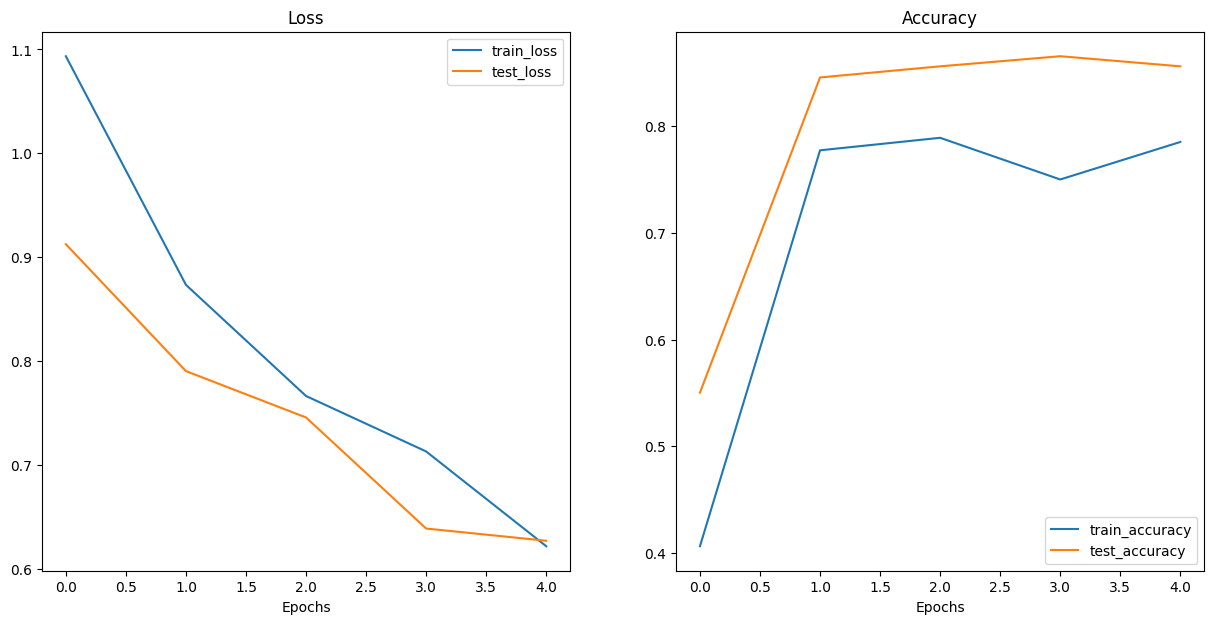

In [23]:
# Let's plot the loss curve 
plot_loss_curves(results=results)

# 6. Let's make some predictions on images from the test set 

**IMPORTANT**:

* Test data must be in the same shape that the data used to train our model.
* Test data must be in the same data dtype.
* Test data must be in the same device.
* Test data must be transformed in the same way train data was.

To do all of this, let's make a function: `pred_and_plot_image()`:

1. Take in a trained model, class names list, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exits.
4. Make sure the model is on the target device
5. Turn the model to 'model.eval()' mode to make sure it's ready for inference (this will, for example, take of the dropout layers).
6. Transform the target image (remember adding batch size 1).
7. Make a prediction on the image by passing to the model.
8. Convert the model's output logits to predictions probabilities using `torch.softmax()`.
9. Convert model`s prediction probabilities to prediction labels using `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probabilitie from step 8.

In [39]:
from torchvision import transforms
from typing import Dict, List, Tuple

def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (224, 224),
                        transform = None,
                        dev: str = "cpu") -> None:
    
    # Getting the image
    import PIL
    from PIL.Image import open
    pil_img = open(image_path)
    
    # Image transformation
    if not transform:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    # Predict on image
    model.to(dev)
    with torch.inference_mode():
        model.eval()
        # Transformation
        img = transform(pil_img)
        
        # Prediction
        logits = model(img.unsqueeze(dim=0).to(dev))
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1)
    
    # Plot the image
    plt.figure(figsize=(15, 7))
    plt.imshow(pil_img)
    title = f"Prediction: {class_names[pred]} | Prob: {probs.max()}"
    plt.axis(False)
    plt.title(title)
    plt.show()

Number of test samples: 75


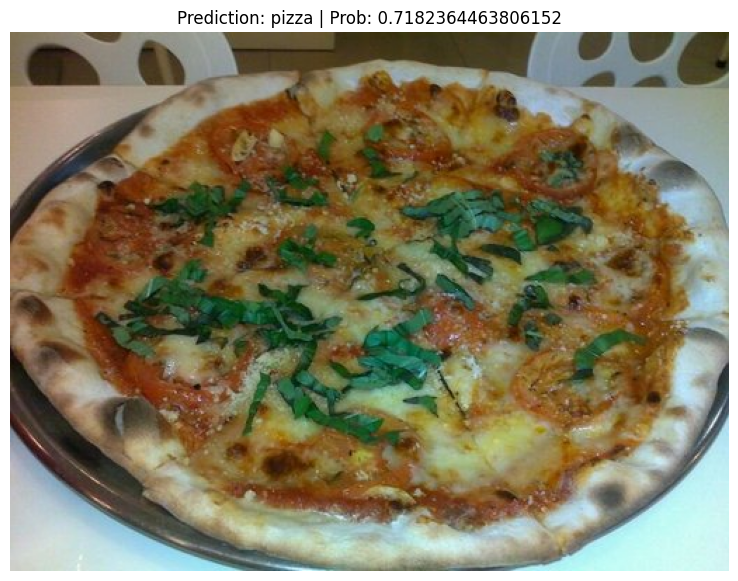

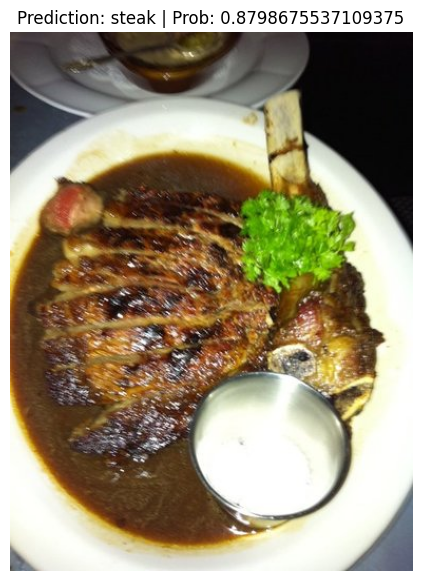

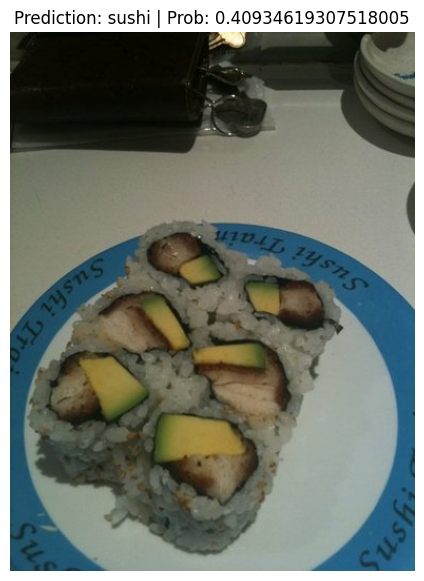

In [51]:
# Now let's get some random images from the tests data
import random
n = 3

test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
print(f"Number of test samples: {len(test_image_path_list)}")
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k = n)
# Make predictions on the images
for image_path in test_image_path_sample:
    real_class = image_path.parent.name 
    pred_and_plot_image(model=model,
                        class_names=class_names,
                        image_path=str(image_path),
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image 

Image already downloaded, skipping this step.


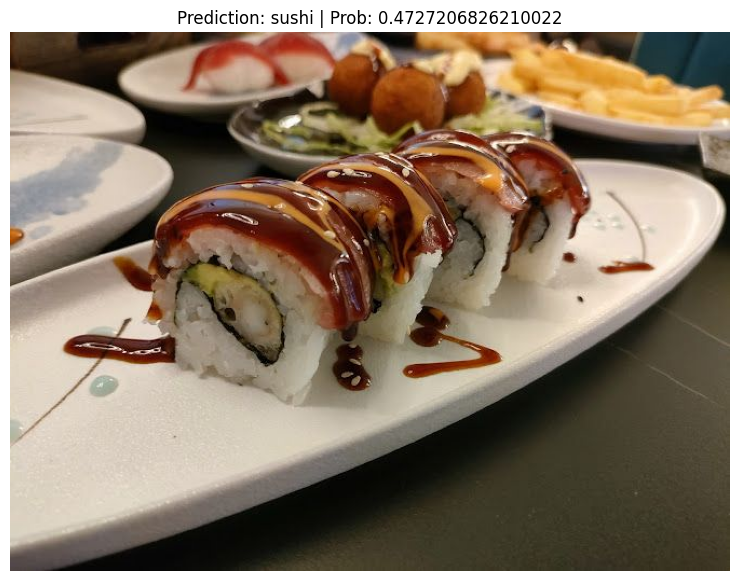

In [65]:
import requests as rq

custom_image_path = data_path/"custom_image.jpg"
if not custom_image_path.exists():
    print(f"Downloading image at: '{custom_image_path}'...")
    url = "https://imgs.search.brave.com/3Ul7nnUJ3C532AlLy9D_RXR98XL4CRDzLN0gFf_Y-x8/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9saDUu/Z29vZ2xldXNlcmNv/bnRlbnQuY29tL3Av/QUYxUWlwTkpmRUFx/a3hnVGZqektTZUwt/ekRGc0Q2VFBKWVYz/bjA0VVRCeUk9dzgw/MC1oNTAwLWstbm8"
    request = rq.get(url=url)
    with open(custom_image_path, "wb") as f:
        f.write(request.content)
else:
    print(f"Image already downloaded, skipping this step.")
pred_and_plot_image(model=model,
                    class_names=class_names,
                    image_size=(224, 224),
                    image_path=".data/custom_image.jpg") # Downloaded in previous sections 

# Extra: saving the model for the exercises

In [71]:
models_path = Path("models")
if not models_path.exists():
    models_path.mkdir()
torch.save(obj=model,
           f=models_path/"transfer_learning_model.pth")
